In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
import matplotlib.pyplot as plt

import xgboost as xgb

In [2]:
# Load the dataset
data = pd.read_csv('/Users/christinethier/Desktop/merged_data.csv')

# Preprocess the data
data_cleaned = data.drop(['Unnamed: 0', 'name', 'winery'], axis=1)  # Adjust as needed
X = data_cleaned.drop('rating', axis=1)
y = data_cleaned['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define preprocessing for numerical and categorical data
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

In [3]:
data.describe()

,Unnamed: 0,rating,year,price_DKK,total_ratings,total_reviews,light-bold,smooth-tannic,dry-sweet,soft-acidic
count,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000
mean,3947.000000,4.194820,2010.545028,840.799951,772.783914,963.003040,0.585282,0.462164,0.152078,0.486437
std,2279.234521,0.358069,6.929609,1438.943777,1301.906205,1576.508854,0.133882,0.182015,0.153446,0.224509
min,0.000000,2.800000,1917.000000,11.750000,25.000000,1.000000,0.231590,0.085450,0.000000,0.008667
25%,1973.500000,3.900000,2008.000000,159.975000,76.000000,125.000000,0.474412,0.340428,0.040919,0.255695
50%,3947.000000,4.300000,2012.000000,375.000000,200.000000,414.000000,0.588094,0.419206,0.084284,0.474183
75%,5920.500000,4.500000,2015.000000,826.080000,1176.000000,1046.000000,0.646982,0.584629,0.231508,0.628518
max,7894.000000,4.900000,2019.000000,23050.680000,14526.000000,12013.000000,0.825000,0.825000,0.586491,0.825000


For random forest & XGBoost the scale of the features doesn't matter. But it gives a nice overview anyway.

In [4]:
numerical_cols

Index(['year', 'price_DKK', 'total_ratings', 'total_reviews', 'light-bold',
       'smooth-tannic', 'dry-sweet', 'soft-acidic'],
      dtype='object')

In [5]:
categorical_cols

Index(['sub_region', 'light-bold-cat', 'smooth-tannic-cat', 'dry-sweet-cat',
       'soft-acidic-cat', 'region', 'cardinal_1', 'cardinal_2'],
      dtype='object')

Let's also for good practice look for null/nan values:

In [6]:
data.isna().any()

Unnamed: 0           False
name                 False
rating               False
sub_region           False
year                 False
price_DKK            False
total_ratings        False
total_reviews        False
light-bold           False
smooth-tannic        False
dry-sweet            False
soft-acidic          False
winery                True
light-bold-cat       False
smooth-tannic-cat    False
dry-sweet-cat        False
soft-acidic-cat      False
region               False
cardinal_1           False
cardinal_2           False
dtype: bool

Since we use XGBoost and Random Forest they can handle the missing values internally.

However, we might as well build a robust model, which can take care of these issues, should they appear.

For our numerical features we impute missing values with the mean and for categorical features we treat unseen categories as nan values. Luckily, we can build this robustness into the model directly:

## XGBoost

Just a qucikly trained model

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ])

# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)

# Create and fit the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)

# Evaluate the model
score = pipeline.score(X_test, y_test)
print(f'Model Score: {score}') # R²


Model Score: 0.8397976064684501


In [8]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['year', 'price_DKK', 'total_ratings', 'total_reviews', 'light-bold',
       'smooth-tannic', 'dry-sweet', 'soft-acidic'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['sub_region', 'light-bold-cat', 'smooth-tannic-cat', 'dry-sweet-cat',
       'soft-acidic-...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=0, ...))])

Hyperparameter tuning as well!

In [16]:
# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)

# Parameters grid to search
param_grid = {
    'model__n_estimators': [400, 500],
    'model__max_depth': [6, 7, 8, 9],
    'model__learning_rate': [0.1]
}

# Make scorer for R2 score
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_parameters)

# Evaluate the model
pipeline = grid_search.best_estimator_
score = pipeline.score(X_test, y_test)
print(f'Mean Squared Error on Training Set: {-best_score}')

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 500}
Mean Squared Error on Training Set: 0.020205651088541624


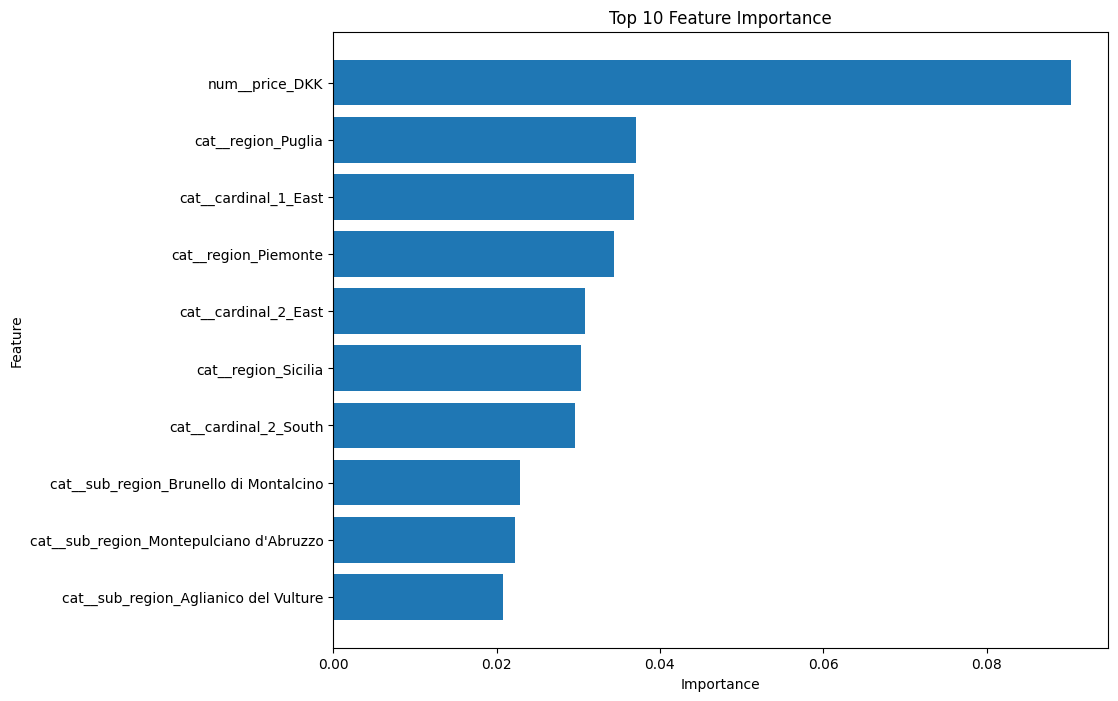

In [17]:
# Assuming 'pipeline' and 'preprocessor' are already defined and the model is fitted

# Get all feature names from the ColumnTransformer
all_feature_names = preprocessor.get_feature_names_out()

# Ensure you have the XGBoost model from the pipeline
xgb_model = pipeline.named_steps['model']

# Obtain feature importances
feature_importances = xgb_model.feature_importances_

# Sort the features by importance and select the top 10
sorted_indices = np.argsort(feature_importances)[-10:]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), np.array(all_feature_names)[sorted_indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.show()


## Random Forest

In [19]:
# Define the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Create and fit the pipeline with Random Forest
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor), ('model', random_forest_model)])
pipeline_rf.fit(X_train, y_train)

# Evaluate the Random Forest model
score_rf = pipeline_rf.score(X_test, y_test)
print(f'Random Forest Model Score: {score_rf}')

Random Forest Model Score: 0.8496014898179943


In [20]:
pipeline_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['year', 'price_DKK', 'total_ratings', 'total_reviews', 'light-bold',
       'smooth-tannic', 'dry-sweet', 'soft-acidic'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['sub_region', 'light-bold-cat', 'smooth-tannic-cat', 'dry-sweet-cat',
       'soft-acidic-cat', 'region', 'cardinal_1', 'cardinal_2'],
      dtype='object'))])),
                ('model', RandomForestRegressor(random_state=0))])

In [23]:
# Define the parameters grid to search
param_grid_rf = {
    'model__n_estimators': [200, 300],
    'model__max_depth': [20, 25],
    'model__min_samples_split': [2, 5]
}

scorer_rf = make_scorer(mean_squared_error, greater_is_better=False)

# Create the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring=scorer_rf, verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

# Best parameters and best score for Random Forest
best_parameters_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Best Parameters for Random Forest:", best_parameters_rf)
print("Best Score for Random Forest:", -best_score_rf)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END model__max_depth=20, model__min_samples_split=5, model__n_estimators=200; total time=  19.7s
[CV] END model__max_depth=20, model__min_samples_split=5, model__n_estimators=200; total time=  19.9s
[CV] END model__max_depth=20, model__min_samples_split=2, model__n_estimators=200; total time=  22.1s
[CV] END model__max_depth=20, model__min_samples_split=2, model__n_estimators=200; total time=  22.1s
[CV] END model__max_depth=20, model__min_samples_split=2, model__n_estimators=200; total time=  22.6s
[CV] END model__max_depth=20, model__min_samples_split=2, model__n_estimators=300; total time=  33.3s
[CV] END model__max_depth=20, model__min_samples_split=2, model__n_estimators=300; total time=  33.5s
[CV] END model__max_depth=20, model__min_samples_split=2, model__n_estimators=300; total time=  33.9s
